## Check Forecast Quality

- create csv files every day by running `get_forecast.ipynb`
- use this notebook to load all forecast of previous days and plot agains real stock prize of last week

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import yfinance as yf
import plotly.graph_objects as go
import plotly.express as px
from finance_monitor.utils import company_to_ticker_mapping

cmap = px.colors.qualitative.Plotly

class ForecastHandler:
    def __init__(self, company="nvidia", folder="."):
        self.company = company
        self.folder = folder
        self.forecasts = dict()
        self.forecast_files = [f for f in os.listdir(self.folder) if f.endswith(".csv") and company in f]
        print("found forecast files:", self.forecast_files)
 
    def load_all_forecasts(self):
        for forecast_file in self.forecast_files:
            date = forecast_file.split("_")[0]
            self.load_forecast(date)
 
    def load_forecast(self, date):
        filename = f'{date}_{self.company}_forecast.csv'
        print('load file '+filename)
        self.forecasts[date] = pd.read_csv(filename)
 
    def get_stock_price_series(self):
        ticker_symbol = company_to_ticker_mapping()[self.company]
        ticker_data = yf.Ticker(ticker_symbol)
        historical_data = ticker_data.history(period='1mo')
        stock_prize = historical_data['Close']
        dates = []
        for date_i in historical_data.index:
            dates.append(pd.Timestamp(year=date_i.year, month=int(date_i.month), day=int(date_i.day)))
 
        #---### todo: dates.append(pd.Timestamp(year=current_year, month=int(day_month[1]), day=int(day_month[0])))
        #print(f"Current stock price of {self.company} is {current_price_usd} USD")
        return stock_prize, dates
 
    def _get_start_date(self, external_start_date):
        oldest_date = None
        for fc in self.forecasts:
            date = self.forecasts[fc]['date']
            if oldest_date is None or pd.Timestamp(date[0]) < oldest_date:
                oldest_date = pd.Timestamp(date[0])
        if external_start_date < oldest_date:
                oldest_date = external_start_date
        return oldest_date

    def plot_forecasts(self):
        current_stock_prize, current_stock_prize_dates = self.get_stock_price_series()
        idx_forecast_plot = 29  # max.number of forecast day to be plotted
        start_date = self._get_start_date(current_stock_prize_dates[0])
        
        fig, ax = plt.subplots(figsize=(10, 5))
        for idx, fc in enumerate(self.forecasts):
            date = pd.to_datetime(self.forecasts[fc]['date'])
            forecast_list = self.forecasts[fc]['forecast']
            ax.plot(date, forecast_list, linestyle='dashed', label=f'Forecast - {fc}', color=cmap[idx % len(cmap)])
            ax.scatter([date[0]], [forecast_list[0]], color=cmap[idx % len(cmap)], label=f'Start Forecast - {fc}', zorder=3)
        # Current and past stock price as red line
        ax.plot(current_stock_prize_dates, current_stock_prize, marker='o', linestyle='-', color='red', label='Current Price')
        ax.set_title(f'{self.company} Forecast')
        ax.set_xlabel('Date')
        ax.set_ylabel('Price / USD')
        ax.legend()
        ax.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.xlim([pd.to_datetime(start_date), date[min(idx_forecast_plot, len(date)-1)]])
        plt.ylim([0, max(max(current_stock_prize), max(forecast_list[:idx_forecast_plot])) * 1.4])

        plt.show()

        fig = go.Figure()
        for idx, fc in enumerate(self.forecasts):
            date = pd.to_datetime(self.forecasts[fc]['date'])
            forecast_list = self.forecasts[fc]['forecast']
            #low = self.forecasts[fc]['low']
            #high = self.forecasts[fc]['high']
            
            fig.add_trace(go.Scatter(
                x=date, y=forecast_list,
                mode='lines', 
                line=dict(dash='dash',color=cmap[np.mod(idx,len(cmap))]),
                name=f'Forecast - {fc}'
            ))

            fig.add_trace(go.Scatter(
                x=[date[0]], y=[forecast_list[0]],
                mode='markers',
                marker=dict(size=8, symbol='circle',color=cmap[np.mod(idx,len(cmap))]),
                name=f'Start Forecast - {fc}'
            ))
            '''
            fig.add_trace(go.Scatter(
                x=list(date) + list(date[::-1]),
                y=list(low) + list(high[::-1]),
                fill='toself',
                fillcolor='rgba(0, 100, 255, 0.2)',
                line=dict(color='rgba(255,255,255,0)'),
                name=f'Confidence Interval - {fc}'
            ))
            '''
        # current and past stock prize as red line
        fig.add_trace(go.Scatter(
            x=current_stock_prize_dates, y=current_stock_prize,
            mode='lines+markers',
            marker=dict(color='red', size=6),
            line=dict(color='red'),
            name='Current Price'
        ))

        fig.update_layout(
            title=f'{self.company} Forecast',
            xaxis_title='Date',
            yaxis_title='Price / USD',
            xaxis=dict(tickangle=-45),
            template='plotly_white',
            legend=dict(
                x=1.05,
                y=1,
                xanchor="left",
                yanchor="top",
                font=dict(size=10)
            )
        )
        fig.update_xaxes(range=[pd.to_datetime(start_date), date[min(idx_forecast_plot, len(date)-1)]])
        fig.update_yaxes(range=[0, max(max(current_stock_prize), max(forecast_list[:idx_forecast_plot])) * 1.4])

        #fig.update_layout(
        #    plot_bgcolor="black",  # Hintergrund der Zeichenfläche
        #    paper_bgcolor="black",  # Gesamter Plot-Hintergrund
        #    font=dict(color="white"),  # Schriftfarbe auf weiß setzen
        #    xaxis=dict(gridcolor="gray"),  # Gitterlinien in Grau
        #    yaxis=dict(gridcolor="gray")
        #)
        # Plot anzeigen
        fig.show()

found forecast files: ['20250312_nvidia_forecast.csv', '20250313_nvidia_forecast.csv', '20250315_nvidia_forecast.csv', '20250317_nvidia_forecast.csv', '20250318_nvidia_forecast.csv', '20250319_nvidia_forecast.csv', '20250329_nvidia_forecast.csv', '20250402_nvidia_forecast.csv', '20250403_nvidia_forecast.csv', '20250407_nvidia_forecast.csv', '20250408_nvidia_forecast.csv', '20250410_nvidia_forecast.csv', '20250418_nvidia_forecast.csv', '20250423_nvidia_forecast.csv', '20250504_nvidia_forecast.csv']
load file 20250312_nvidia_forecast.csv
load file 20250313_nvidia_forecast.csv
load file 20250315_nvidia_forecast.csv
load file 20250317_nvidia_forecast.csv
load file 20250318_nvidia_forecast.csv
load file 20250319_nvidia_forecast.csv
load file 20250329_nvidia_forecast.csv
load file 20250402_nvidia_forecast.csv
load file 20250403_nvidia_forecast.csv
load file 20250407_nvidia_forecast.csv
load file 20250408_nvidia_forecast.csv
load file 20250410_nvidia_forecast.csv
load file 20250418_nvidia_for

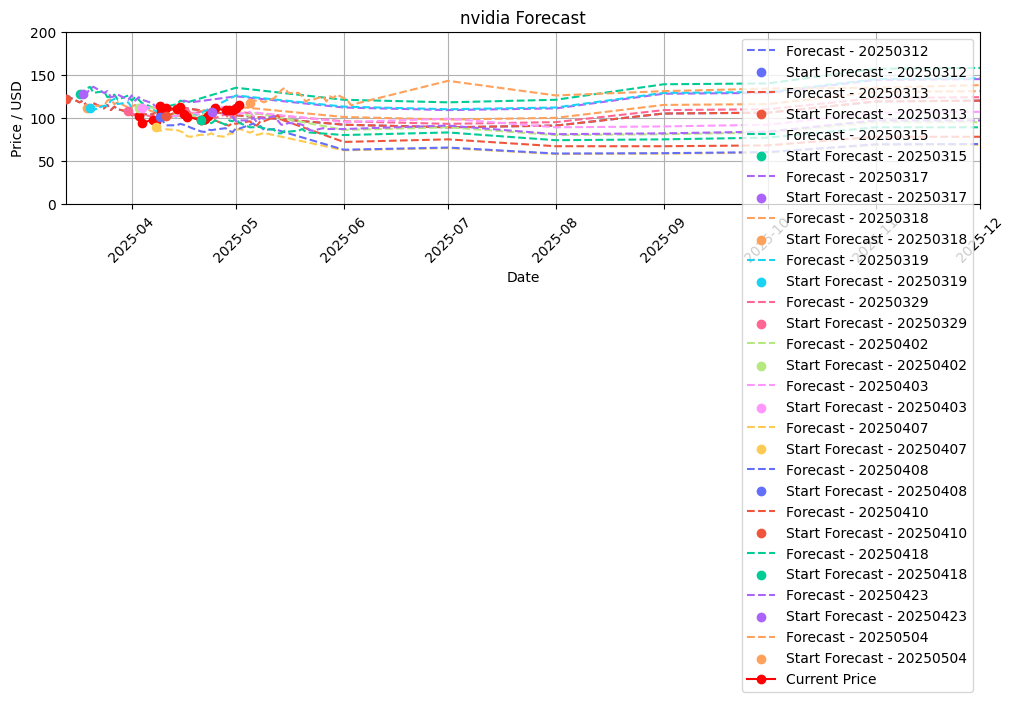

In [2]:
fh=ForecastHandler(company='nvidia')
fh.load_all_forecasts()
fh.plot_forecasts()

found forecast files: ['20250312_rhm-aktie_forecast.csv', '20250313_rhm-aktie_forecast.csv', '20250315_rhm-aktie_forecast.csv', '20250317_rhm-aktie_forecast.csv', '20250318_rhm-aktie_forecast.csv', '20250319_rhm-aktie_forecast.csv', '20250329_rhm-aktie_forecast.csv', '20250402_rhm-aktie_forecast.csv', '20250403_rhm-aktie_forecast.csv', '20250407_rhm-aktie_forecast.csv', '20250408_rhm-aktie_forecast.csv', '20250410_rhm-aktie_forecast.csv', '20250418_rhm-aktie_forecast.csv', '20250423_rhm-aktie_forecast.csv', '20250504_rhm-aktie_forecast.csv']
load file 20250312_rhm-aktie_forecast.csv
load file 20250313_rhm-aktie_forecast.csv
load file 20250315_rhm-aktie_forecast.csv
load file 20250317_rhm-aktie_forecast.csv
load file 20250318_rhm-aktie_forecast.csv
load file 20250319_rhm-aktie_forecast.csv
load file 20250329_rhm-aktie_forecast.csv
load file 20250402_rhm-aktie_forecast.csv
load file 20250403_rhm-aktie_forecast.csv
load file 20250407_rhm-aktie_forecast.csv
load file 20250408_rhm-aktie_for

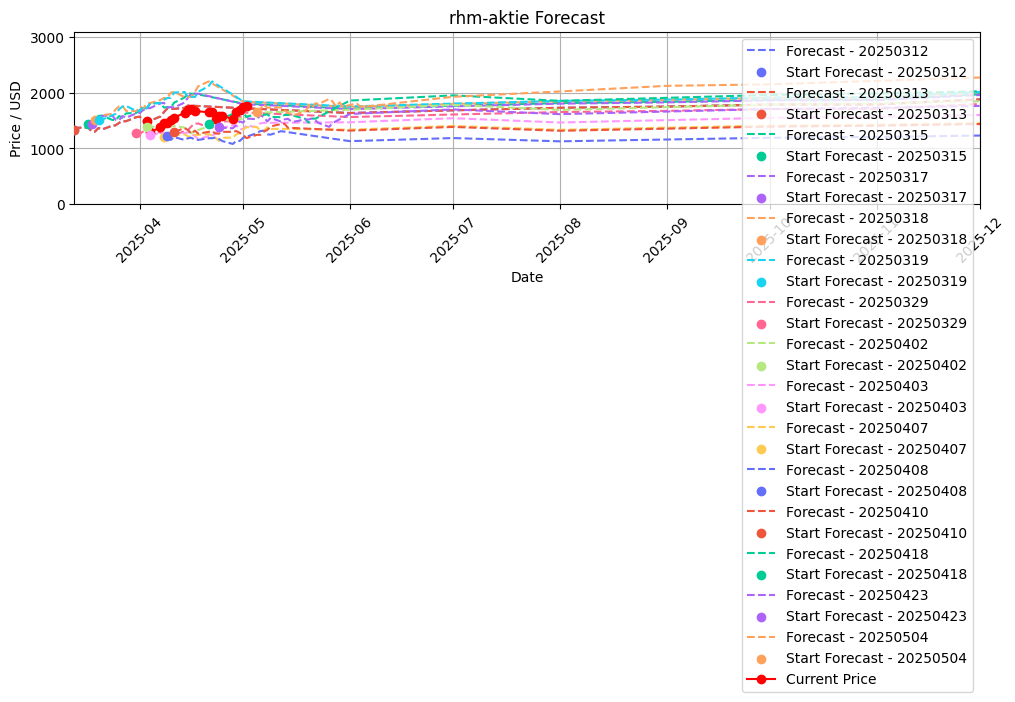

In [3]:
fh=ForecastHandler(company='rhm-aktie')
fh.load_all_forecasts()
fh.plot_forecasts()

found forecast files: ['20250329_netflix_forecast.csv', '20250402_netflix_forecast.csv', '20250403_netflix_forecast.csv', '20250407_netflix_forecast.csv', '20250408_netflix_forecast.csv', '20250410_netflix_forecast.csv', '20250418_netflix_forecast.csv', '20250423_netflix_forecast.csv', '20250504_netflix_forecast.csv']
load file 20250329_netflix_forecast.csv
load file 20250402_netflix_forecast.csv
load file 20250403_netflix_forecast.csv
load file 20250407_netflix_forecast.csv
load file 20250408_netflix_forecast.csv
load file 20250410_netflix_forecast.csv
load file 20250418_netflix_forecast.csv
load file 20250423_netflix_forecast.csv
load file 20250504_netflix_forecast.csv


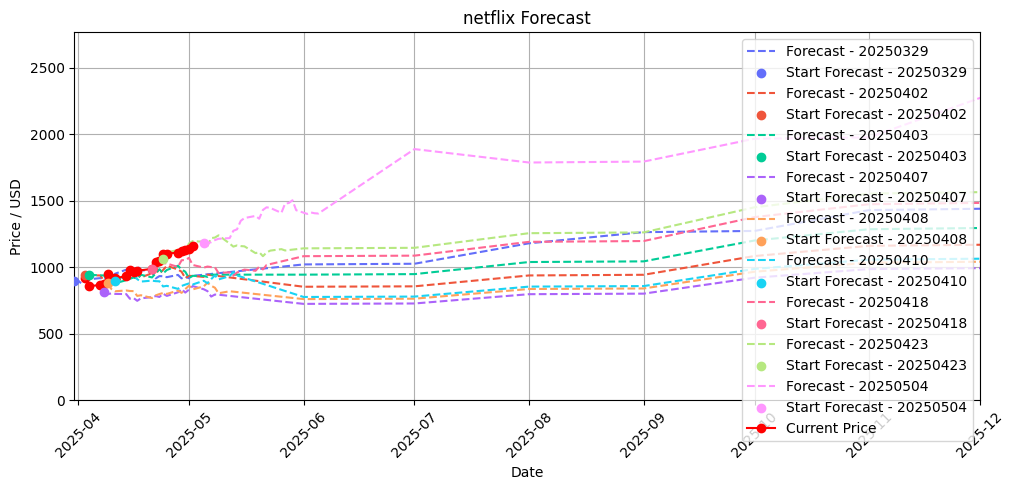

In [4]:
fh=ForecastHandler(company='netflix')
fh.load_all_forecasts()
fh.plot_forecasts()

found forecast files: ['20250402_wmt-stock_forecast.csv', '20250403_wmt-stock_forecast.csv', '20250407_wmt-stock_forecast.csv', '20250408_wmt-stock_forecast.csv', '20250410_wmt-stock_forecast.csv', '20250418_wmt-stock_forecast.csv', '20250423_wmt-stock_forecast.csv', '20250504_wmt-stock_forecast.csv']
load file 20250402_wmt-stock_forecast.csv
load file 20250403_wmt-stock_forecast.csv
load file 20250407_wmt-stock_forecast.csv
load file 20250408_wmt-stock_forecast.csv
load file 20250410_wmt-stock_forecast.csv
load file 20250418_wmt-stock_forecast.csv
load file 20250423_wmt-stock_forecast.csv
load file 20250504_wmt-stock_forecast.csv


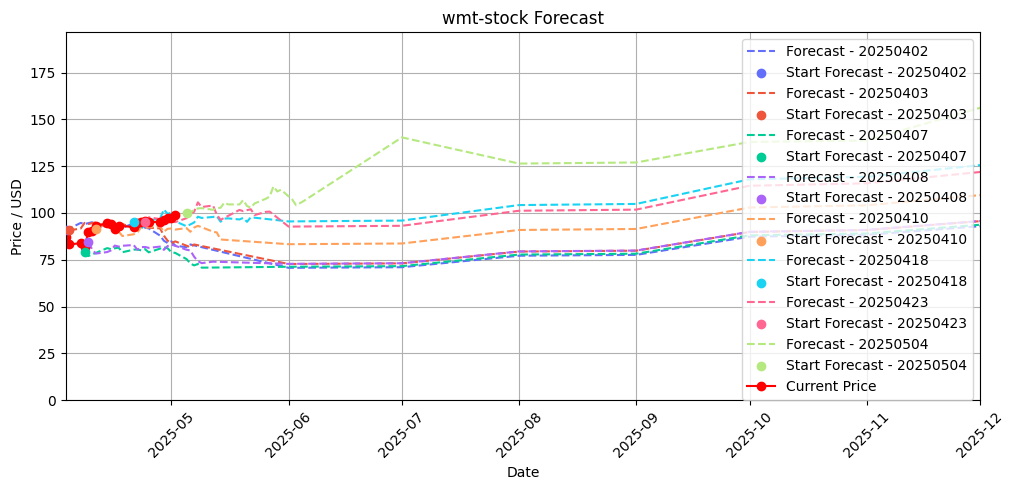

In [5]:
fh=ForecastHandler(company='wmt-stock')
fh.load_all_forecasts()
fh.plot_forecasts()

found forecast files: ['20250402_xpeng_forecast.csv', '20250403_xpeng_forecast.csv', '20250407_xpeng_forecast.csv', '20250408_xpeng_forecast.csv', '20250410_xpeng_forecast.csv', '20250418_xpeng_forecast.csv', '20250423_xpeng_forecast.csv', '20250504_xpeng_forecast.csv']
load file 20250402_xpeng_forecast.csv
load file 20250403_xpeng_forecast.csv
load file 20250407_xpeng_forecast.csv
load file 20250408_xpeng_forecast.csv
load file 20250410_xpeng_forecast.csv
load file 20250418_xpeng_forecast.csv
load file 20250423_xpeng_forecast.csv
load file 20250504_xpeng_forecast.csv


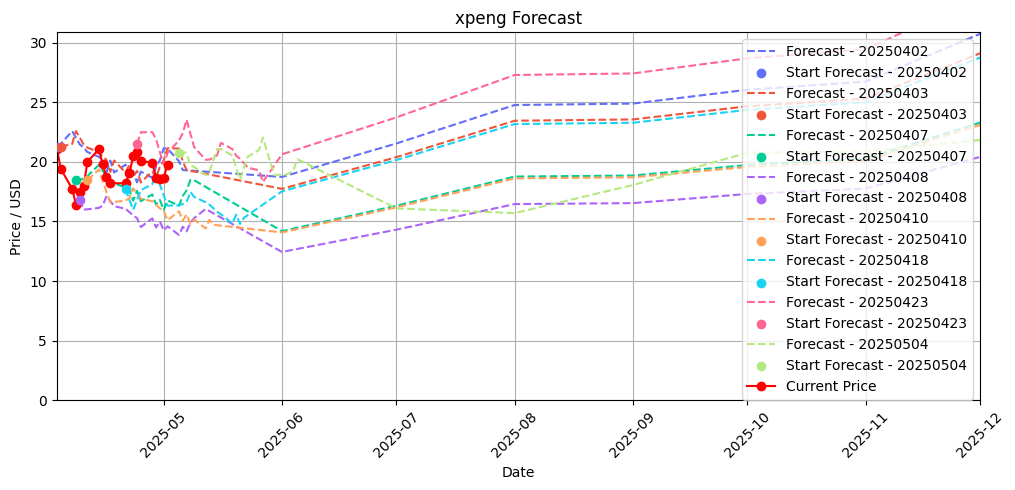

In [6]:
fh=ForecastHandler(company='xpeng')
fh.load_all_forecasts()
fh.plot_forecasts()

found forecast files: ['20250402_mo-stock_forecast.csv', '20250403_mo-stock_forecast.csv', '20250407_mo-stock_forecast.csv', '20250408_mo-stock_forecast.csv', '20250410_mo-stock_forecast.csv', '20250418_mo-stock_forecast.csv', '20250423_mo-stock_forecast.csv', '20250504_mo-stock_forecast.csv']
load file 20250402_mo-stock_forecast.csv
load file 20250403_mo-stock_forecast.csv
load file 20250407_mo-stock_forecast.csv
load file 20250408_mo-stock_forecast.csv
load file 20250410_mo-stock_forecast.csv
load file 20250418_mo-stock_forecast.csv
load file 20250423_mo-stock_forecast.csv
load file 20250504_mo-stock_forecast.csv


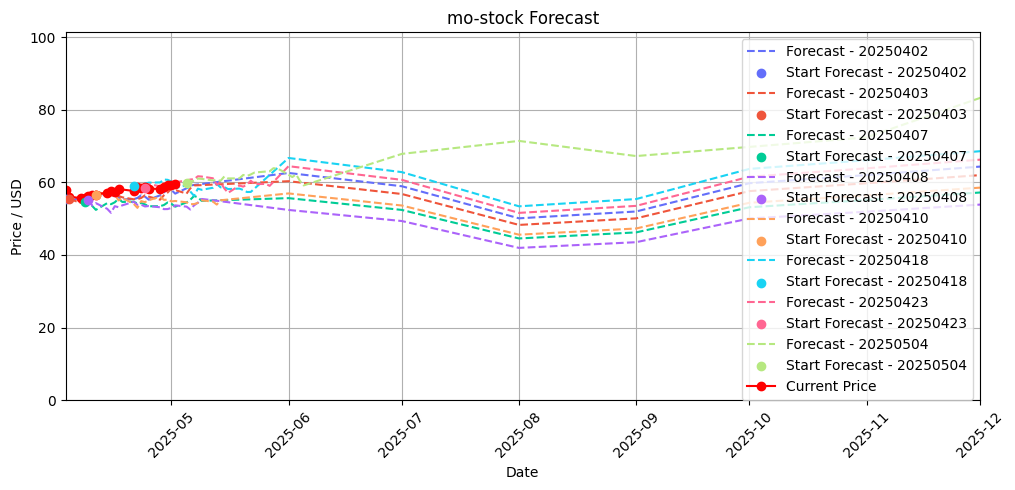

In [7]:
fh=ForecastHandler(company='mo-stock')
fh.load_all_forecasts()
fh.plot_forecasts()